In [1]:
import csv
import time
from sklearn.cluster import KMeans
from scipy.spatial import distance
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
def getFeatures(name,count):
    siftFeatures = []
    detectedRegions = []
    for i in range(count):
        file = './' + name +'_sift_features/' + str(i+1) + '_' + name + '_sift.csv'
        csvFile = csv.reader(open(file))
        regions = 0
        for line in csvFile:
            siftFeatures.append(line[4:])
            regions += 1
        detectedRegions.append(regions)
    return detectedRegions , siftFeatures

In [3]:
def getClusterDescriptors(siftFeatures,clusters,x):
    try:
        kmeans = pickle.load(open("pickleFiles/Kmeans_"+str(clusters)+"_"+str(x)+".pickle", "rb"))
        print("Loaded kmeans Pickle file!!!")
    except (OSError, IOError) as e:
        print("no kmeans pickle file found!!! Creating one")
        kmeans = KMeans(n_clusters = clusters)
        kmeans.fit(siftFeatures)
        pickle.dump(kmeans, open("pickleFiles/Kmeans_"+str(clusters)+"_"+str(x)+".pickle", "wb"))
        print("Saved kmeans pickle file!!     "+ "pickleFiles/Kmeans_"+str(clusters)+"_"+str(x)+".pickle")
    return kmeans.cluster_centers_

In [4]:
def getVisualWords(siftFeatures,regions_train,clusterCenters,clusters,name,save = False):
    try:
        vocab = pickle.load(open("pickleFiles/vocab_"+name+"_"+str(clusters)+"_"+str(len(regions_train))+".pickle", "rb"))
        print("loaded "+name+" vocab pickle file!!!")
    except (OSError, IOError) as e:
        print("no "+name+" vocab pickle file found!!! Creating one")
        def getDistance(f):
            f1 = [float(i) for i in f]
            dist = []
            for i in clusterCenters:
                d = np.linalg.norm(i-f1)
                dist.append(d)
            return dist
        vocab = []
        features = [0] * clusters
        count = 0
        temp = 0
        for f in siftFeatures:
            dist = getDistance(f)
            i = dist.index(min(dist))
            features[i] += 1
            count += 1
            if count == regions_train[temp]:
                vocab.append(features)
                features = [0] * clusters
                count = 0
                temp += 1
        if(save == True):
            pickle.dump(vocab,open("pickleFiles/vocab_"+name+"_"+str(clusters)+"_"+str(len(regions_train))+".pickle", "wb"))
            print("Saved "+name+" vocab pickle file!!")
    return vocab

In [5]:
print("Reading Files!!!")
numOfTrainSamples = 1888
numOfTestSamples = 800
regions_train,features_train = getFeatures('train' , numOfTrainSamples)
regions_test,features_test = getFeatures('test' , numOfTestSamples)
print("Number of Images in train " + str(len(regions_train)))
print(len(features_train))
print("Number of Images in test " + str(len(regions_test)))


Reading Files!!!
Loaded Features and Regions Pickle file for train!!!
Loaded Features and Regions Pickle file for test!!!
Number of Images in train 1888
413971
Number of Images in test 800


In [6]:
tic = time.time()
clusters = 64
clusterCenters = getClusterDescriptors(features_train,clusters,numOfTrainSamples)
print(clusterCenters)
print("Time taken to calculate Culsters: " + str(time.time() - tic))

Loaded kmeans Pickle file!!!
[[ 22.09787034  18.59442531  20.48042593 ...,  21.88474789  15.24757282
   16.20137801]
 [ 50.15662331  10.73798779   3.62012211 ...,   9.43230688   6.29360234
    7.14587205]
 [ 23.33753582   5.75702006   4.01518625 ...,  10.77464183   8.02378223
    9.99312321]
 ..., 
 [ 22.48390188  12.04426984  10.58853967 ...,  11.12763511  12.54580299
   13.98294366]
 [ 36.61664434  13.41461962   6.50513622 ...,  22.44379932  48.61738872
   56.54027095]
 [ 26.12134776  13.14273281   9.60835509 ...,  18.65025488  10.90762153
    9.70272286]]
Time taken to calculate Culsters: 0.005561351776123047


In [7]:
tic = time.time()
vocab_Train = getVisualWords(features_train,regions_train,clusterCenters,clusters,"train",save = True)
vocab_Test = getVisualWords(features_test,regions_test,clusterCenters,clusters,"test",save = True)
print("Time taken to represent image by normalized counts of visual words: " + str(time.time()-tic))

loaded train vocab pickle file!!!
loaded test vocab pickle file!!!
Time taken to represent image by normalized counts of visual words: 0.0209963321685791


In [8]:
with open( './train_labels.csv','rU') as csvfile:
        csvfile = csv.reader(csvfile, delimiter=',')
        train_labels = [int(i) for i in list(csvfile)[0]]

with open( './test_labels.csv','rU') as csvfile:
        csvfile = csv.reader(csvfile, delimiter=',')
        test_labels = [int(i) for i in list(csvfile)[0]]
#print(train_labels)

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
def kNN_classifer(train_images, train_labels, k_NN):
    knn = KNeighborsClassifier(n_neighbors = k_NN)
    knn.fit(train_images, train_labels)
    return knn
accuracies = []
for i in range(1,21):
    k_NN = i
    kNN_model = kNN_classifer(vocab_Train, train_labels, k_NN)
    test_prediction = kNN_model.predict(vocab_Test)
    #print (classification_report(test_labels, test_prediction, target_names=['1', '2', '3', '4', '5', '6', '7', '8']))
    categorization_accuracy = accuracy_score(test_labels, test_prediction)
    print (categorization_accuracy)
    accuracies.append((i,categorization_accuracy))

0.45875
0.435
0.4625
0.5
0.51
0.52
0.5375
0.52875
0.51875
0.535
0.52375
0.535
0.5325
0.52
0.52375
0.53625
0.54
0.535
0.535
0.5325


In [10]:
accuracies

[(1, 0.45874999999999999),
 (2, 0.435),
 (3, 0.46250000000000002),
 (4, 0.5),
 (5, 0.51000000000000001),
 (6, 0.52000000000000002),
 (7, 0.53749999999999998),
 (8, 0.52875000000000005),
 (9, 0.51875000000000004),
 (10, 0.53500000000000003),
 (11, 0.52375000000000005),
 (12, 0.53500000000000003),
 (13, 0.53249999999999997),
 (14, 0.52000000000000002),
 (15, 0.52375000000000005),
 (16, 0.53625),
 (17, 0.54000000000000004),
 (18, 0.53500000000000003),
 (19, 0.53500000000000003),
 (20, 0.53249999999999997)]

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

In [14]:
cm = confusion_matrix(test_labels, list(test_prediction),labels=[1, 2, 3, 4, 5, 6, 7, 8] )

In [15]:
cm

array([[65,  1, 12,  1,  6, 11,  3,  1],
       [ 0, 89,  0,  0,  7,  1,  3,  0],
       [36,  0, 32,  3,  4, 14,  6,  5],
       [ 4,  9,  1, 57,  1,  7, 13,  8],
       [ 8,  6,  2,  0, 48, 27,  8,  1],
       [22,  5,  5,  2,  8, 44,  9,  5],
       [ 3,  8,  2, 10,  9,  8, 59,  1],
       [11,  4,  5, 17,  9, 13,  9, 32]], dtype=int64)

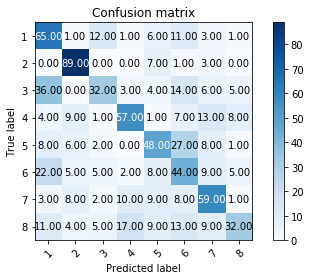

In [22]:
cmap=plt.cm.Blues
title = 'Confusion matrix'
classes=[1, 2, 3, 4, 5, 6, 7, 8]
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0]),xticklabels=classes, yticklabels=classes,title=title,ylabel='True label',xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()